In [15]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import json
import csv

In [16]:
def max_abs_scale(series):
    return series / series.abs().max()

image_order = ["500b", "256Kb", "1Mb", "15Mb"]

color_mapping = {
    "resnet34": "#f0e68c",
    "resnet152": "#27ae60",
    "resnet18": "#17becf",
    "resnet50": "#ff7f0e"
}

bar_width = 0.18

#### Energy

In [17]:
headers = ['duration_seconds', 'cpu0_package_joules', 'cpu0_dram_joules', 'cpu1_package_joules', 'cpu1_dram_joules', 'image', 'model']
data = []

for dir in os.listdir("result/energy"):
    # For each subfolder in Energy folder (1Mb.JPEG)
        dir_path = os.path.join("result/energy", dir)
        image = dir.replace(".JPEG", "")

        for file in os.listdir(dir_path):
            # For each file in the subfolder (pillow1Mb.JPEG.txt)
            file_paht = os.path.join(dir_path, file)
            model = file.replace(image+".JPEG.txt", "")

            with open(file_paht, 'r') as file:
                lines = file.readlines()
            
            for line in lines:
                line = line.strip()
                if line.startswith('duration_seconds'):
                    duration_seconds = line.split('=')[1]
                elif line.startswith('cpu0_package_joules'):
                    cpu0_package_joules = line.split('=')[1]
                elif line.startswith('cpu0_dram_joules'):
                    cpu0_dram_joules = line.split('=')[1]
                elif line.startswith('cpu1_package_joules'):
                    cpu1_package_joules = line.split('=')[1]
                elif line.startswith('cpu1_dram_joules'):
                    cpu1_dram_joules = line.split('=')[1]

                    # Append the extracted values to the data list
                    data.append([duration_seconds, 
                                 cpu0_package_joules, 
                                 cpu0_dram_joules, 
                                 cpu1_package_joules, 
                                 cpu1_dram_joules, 
                                 image, 
                                 model])

with open("result/energy.csv", 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(headers)  # Write the header
        writer.writerows(data)    # Write the data

In [18]:
df = pd.read_csv("result/energy.csv")
df["energy"] = df["cpu0_package_joules"] + df["cpu1_package_joules"]
# df.head()

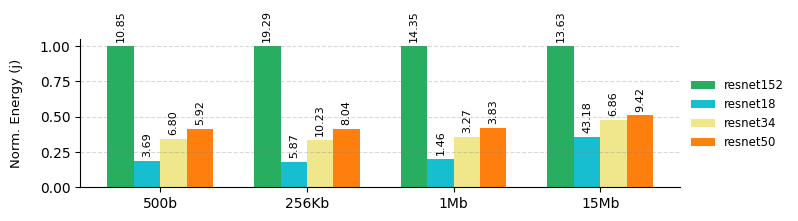

In [19]:
dftt = df.copy()
mean_df = dftt.groupby(['model', 'image'], as_index=False)['cpu0_package_joules'].mean()
mean_df.rename(columns={'cpu0_package_joules': 'mean_cpu0_package_joules'}, inplace=True)
std_df = dftt.groupby(['model', 'image'], as_index=False)['cpu0_package_joules'].std()
std_df.rename(columns={'cpu0_package_joules': 'std_cpu0_package_joules'}, inplace=True)

dftt = std_df.merge(mean_df, on=['model', 'image'])

dfe_max_abs = dftt.copy()

dfe_max_abs['mean_cpu0_package_joules'] = dfe_max_abs.groupby('image')['mean_cpu0_package_joules'].transform(max_abs_scale)

dfe_max_abs['image'] = pd.Categorical(dfe_max_abs['image'], categories=image_order, ordered=True)

dfe_max_abs = dfe_max_abs.sort_values(['model', 'image'])

# Define the libraries and image sizes
models = dfe_max_abs['model'].unique()
image_sizes = dfe_max_abs['image'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.3))

# Set the positions of the bars on the x-axis
positions = np.arange(len(image_sizes))

# Plot each image size
for i, model in enumerate(models):
    subset = dfe_max_abs[dfe_max_abs['model'] == model]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['mean_cpu0_package_joules'], width=bar_width, label=model, color=color_mapping[model])

    for bar, std in zip(bars, subset['std_cpu0_package_joules']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

# Set the labels and title
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
ax.set_ylabel('Norm. Energy (j)', fontsize=9.5, labelpad=12)
ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(image_sizes)

ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=8.5
)
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Times, speaces, props, ... etc

In [22]:
def parse_json_objects(log_content):
    json_objects = []
    buffer = ""
    brace_count = 0
    for char in log_content:
        buffer += char
        if char == '{':
            brace_count += 1
        elif char == '}':
            brace_count -= 1
        
        if brace_count == 0 and buffer.strip():
            try:
                json_objects.append(json.loads(buffer.strip()))
                buffer = ""
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                buffer = ""

    return json_objects

# Read the contents of the log file
with open('result/result.txt', 'r') as file:
    log_content = file.read()

# Parse the log content into JSON objects
json_objects = parse_json_objects(log_content)

# Define the CSV file headers
headers = ["label", "prediction_time", "index", "image", "model", "download_time", "model_size", "model_load_time", "prob"]

# Open the CSV file for writing
with open('result/result.csv', 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=headers)
    writer.writeheader()

    # Process each JSON object
    for data in json_objects:
        try:
            # Write the row to the CSV file
            writer.writerow({
                "label": data["label"],
                "prediction_time": data["prediction_time"],
                "model_load_time": data["model_load_time"],
                "image": data["image"].replace(".JPEG", ""),
                "index": data["index"],
                "model": data["model"],
                "download_time": data["download_time"],
                "model_size": data["model_size"],
                "prob": data["prob"]
            })
        except KeyError as e:
            print(f"Missing key in data: {e}")

print("CSV file has been created successfully.")

CSV file has been created successfully.


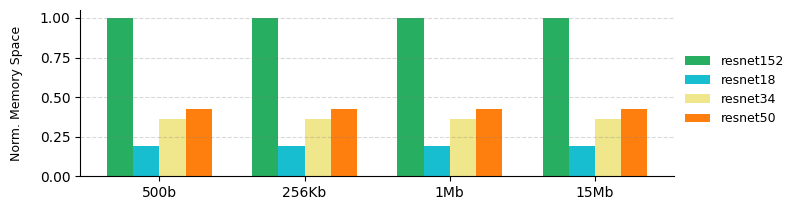

In [26]:
df = pd.read_csv("result/result.csv")
dfct = df.copy()

dfct = dfct.groupby(['model', 'image'], as_index = False)['model_size'].mean()
dfct['normalized_compute_time'] = dfct.groupby('image')['model_size'].transform(max_abs_scale)
dfct['image'] = pd.Categorical(dfct['image'], categories=image_order, ordered=True)
dfct = dfct.sort_values(['model', 'image'])

# Define the libraries and image sizes
models = dfct['model'].unique()
image_sizes = dfct['image'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(image_sizes))

# Plot each image size
for i, model in enumerate(models):
    subset = dfct[dfct['model'] == model]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=model, color=color_mapping[model])

# Set the labels and title
ax.set_ylabel('Norm. Memory Space', fontsize=9, labelpad=12)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(image_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=9
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Probality Prediction

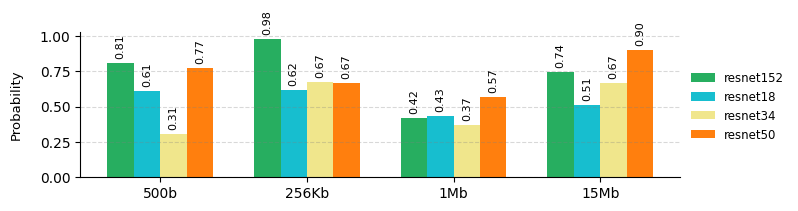

In [25]:
dfct = df.copy()

dfct = dfct.groupby(['model', 'image'], as_index = False)['prob'].mean()

dfct['image'] = pd.Categorical(dfct['image'], categories=image_order, ordered=True)

dfct = dfct.sort_values(['model', 'image'])

# Define the libraries and image sizes
models = dfct['model'].unique()
image_sizes = dfct['image'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2.2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(image_sizes))

# Plot each image size
for i, model in enumerate(models):
    subset = dfct[dfct['model'] == model]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['prob'], width=bar_width, label=model, color=color_mapping[model])

    for bar, prop in zip(bars, subset['prob']):
        height = bar.get_height()
        ax.annotate(f'{prop:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=8, rotation=90)

# Set the labels and title
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

ax.set_ylabel('Probability', fontsize=9.5, labelpad=12)

ax.spines[['right', 'top']].set_visible(False)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(image_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=8.5
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Compute time

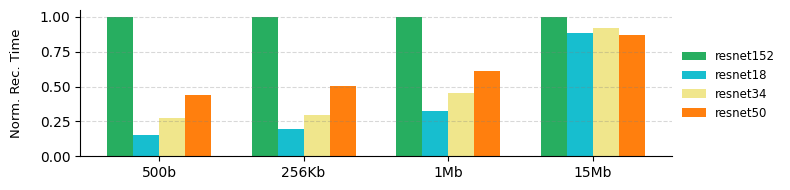

In [27]:
dfct = df.copy()

dfct = dfct.groupby(['model', 'image'], as_index = False)['prediction_time'].mean()

dfct['normalized_compute_time'] = dfct.groupby('image')['prediction_time'].transform(max_abs_scale)

dfct['image'] = pd.Categorical(dfct['image'], categories=image_order, ordered=True)

dfct = dfct.sort_values(['model', 'image'])

# Define the libraries and image sizes
models = dfct['model'].unique()
image_sizes = dfct['image'].unique()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 2))

# Set the positions of the bars on the x-axis
positions = np.arange(len(image_sizes))

# Plot each image size
for i, model in enumerate(models):
    subset = dfct[dfct['model'] == model]
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, subset['normalized_compute_time'], width=bar_width, label=model, color=color_mapping[model])

# Set the labels and title
ax.set_ylabel('Norm. Rec. Time', fontsize=9.5, labelpad=12)

ax.spines[['right', 'top']].set_visible(False)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)

# Set the x-ticks and labels
ax.set_xticks(positions + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(image_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=8.5
)

# plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Total Time

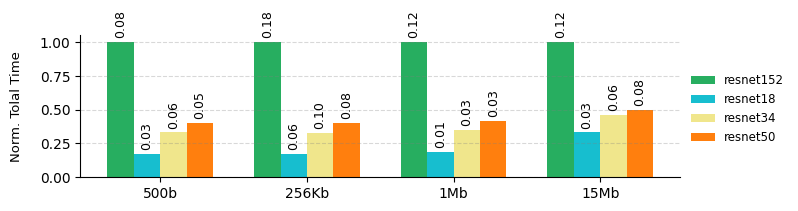

In [28]:
bar_width = 0.18

df["total_time"] =  df["prediction_time"] + df["download_time"] + df["model_load_time"]

dftt = df.copy()

mean_df = dftt.groupby(['model', 'image'], as_index=False)['total_time'].mean()
mean_df.rename(columns={'total_time': 'mean_total_time'}, inplace=True)
std_df = dftt.groupby(['model', 'image'], as_index=False)['total_time'].std()
std_df.rename(columns={'total_time': 'std_total_time'}, inplace=True)

dftt = std_df.merge(mean_df, on=['model', 'image'])

dftt['normalized_total_time'] = dftt.groupby('image')['mean_total_time'].transform(max_abs_scale)

dftt['image'] = pd.Categorical(dftt['image'], categories=image_order, ordered=True)

dftt = dftt.sort_values(['model', 'image'])

models = dftt['model'].unique()
image_sizes = dftt['image'].unique()

fig, ax = plt.subplots(figsize=(8, 2.2))

positions = np.arange(len(image_sizes))

for i, model in enumerate(models):
    subset = dftt[dftt['model'] == model]
    bar_positions = positions + i * bar_width
    bars = ax.bar(bar_positions, subset['normalized_total_time'], width=bar_width, label=model, color=color_mapping[model])

    for bar, std in zip(bars, subset['std_total_time']):
        height = bar.get_height()
        ax.annotate(f'{std:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9, rotation=90)


ax.set_ylabel('Norm. Tolal Time', fontsize=9.5, labelpad=12)
ax.grid(True, axis='y', linestyle='--', color='gray', alpha=0.3)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks(positions + bar_width * (len(models) - 1) / 2)
ax.set_xticklabels(image_sizes)
ax.legend(
    bbox_to_anchor=(1, 0.8), loc='upper left', ncols = 1, frameon=False, fontsize=8.5
)

plt.tight_layout()
plt.show()